In [ ]:
import scikitplot as skplt

import pandas as pd 
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
df = pd.read_csv('./data/authority_dataset.csv')
df

/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/authority/data


,ad,auth
0,north korea officially has no corona cases how...,1
1,it seems difficult to stand for something one ...,0
2,senator bernie sanders held a rally with randy...,1
3,life gets busy—don’t wait to send back your ba...,0
4,some issues feel impossible to compromise on b...,1
...,...,...
49661,a recent poll shows sherrod with just a one po...,0
49662,today’s donor goal ⃣ ⃣ ⃣ our endofquarter dead...,0
49663,you’ve been selected after a year of chaos hat...,1
49664,after receiving the corona vaccine a video tha...,0


In [ ]:
norm_train, norm_test, y_train, y_test  = train_test_split(df['ad'], df['auth'], test_size = 0.33, random_state=42)

In [ ]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('nfi', 54255), ('<PAD>', 0), 1)

In [ ]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((33276, 1000), (16390, 1000))

In [ ]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a simple artificial neural network for binary text classification
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional global max pooling layer  
            - A fully connected layer with units number of units
            - A sigmoid activation layer to produce output
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
VOCAB_SIZE = len(t.word_index)

EMBEDDING_DIM = 50
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          2712800   
                                                                 
 dropout (Dropout)           (None, 1000, 50)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [ ]:
# Train the neural net and evaluate results 
# the model is already trained and saved in the ann_model.h5 file
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.33, verbose=1)

Epoch 1/5
697/697 [==============================] - 40s 56ms/step - loss: 0.4848 - accuracy: 0.7724 - val_loss: 0.2128 - val_accuracy: 0.9542
Epoch 2/5
697/697 [==============================] - 38s 55ms/step - loss: 0.1772 - accuracy: 0.9457 - val_loss: 0.0973 - val_accuracy: 0.9801
Epoch 3/5
697/697 [==============================] - 39s 56ms/step - loss: 0.0861 - accuracy: 0.9765 - val_loss: 0.0693 - val_accuracy: 0.9832
Epoch 4/5
697/697 [==============================] - 39s 56ms/step - loss: 0.0538 - accuracy: 0.9865 - val_loss: 0.0632 - val_accuracy: 0.9833
Epoch 5/5
697/697 [==============================] - 39s 55ms/step - loss: 0.0356 - accuracy: 0.9909 - val_loss: 0.0633 - val_accuracy: 0.9827


513/513 [==============================] - 2s 3ms/step - loss: 0.0594 - accuracy: 0.9830
Accuracy: 98.30%
              precision    recall  f1-score   support

no-authority       0.98      0.99      0.98      8190
   authority       0.99      0.98      0.98      8200

    accuracy                           0.98     16390
   macro avg       0.98      0.98      0.98     16390
weighted avg       0.98      0.98      0.98     16390

confusion matrix:
[[8100   90]
 [ 188 8012]]



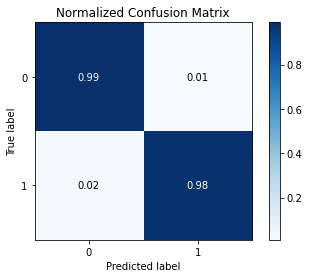

In [ ]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

print(metrics.classification_report(y_test, predictions, target_names=['no-authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

7/7 [==============================] - 0s 6ms/step - loss: 2.1183 - accuracy: 0.7450
Accuracy: 74.50%
7/7 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

no authority       0.73      0.78      0.76       102
   authority       0.76      0.70      0.73        98

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200

confusion matrix:
[[80 22]
 [29 69]]



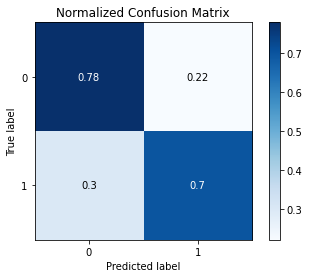

In [ ]:
# sample dataset contains manually annotated data
df_val = pd.read_csv('./data/sample_auth.csv')

val_sequences = t.texts_to_sequences(df_val['ad'])
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_val = df_val['authority']

scores = model.evaluate(X_val, y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

prediction_probs = model.predict(X_val, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

print(metrics.classification_report(y_val, predictions, target_names=[ 'no authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val,predictions))
print()

skplt.metrics.plot_confusion_matrix(y_val, predictions, normalize=True)
plt.show()